# Bayesian Nonparametric Market Segmentation Algorithm
Reference: Nishi, Hayato, Yasushi Asami, and Chihiro Shimizu. "The illusion of a hedonic price function: Nonparametric interpretable segmentation for hedonic inference." Journal of Housing Economics 52 (2021): 101764. https://doi.org/10.1016/j.jhe.2021.101764

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import BayesianMarketSegmentation

## Case 1: dummy is not included
### Build toy dataset

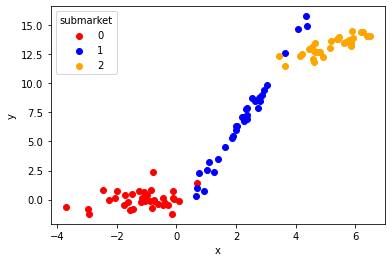

In [2]:
K = 3

mu = np.array([-1, 2, 5])
tau = np.array([1, 1.1, 0.8])

beta = np.array([0.1, 4, 1])
alpha = np.array([0.0, -2, 8])
sigma = np.array([0.8, 0.5, 0.4])

def toy_dataset(N):

    z = np.random.choice(range(K), size=N, replace=True)
    x = np.random.normal(loc=mu[z], scale=tau[z])

    y = alpha[z] + beta[z] * x + np.random.normal(scale=sigma[z])

    return y, x, z

N = 100
y, x, z = toy_dataset(N)

color = ["Red", "Blue", "Orange"]
for k in range(K):
    plt.scatter(x[z==k], y[z==k], label=k, c=color[k])
plt.legend(title="submarket")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Model
Infinite Gaussian Regression Mixture Model (IGRMM)

In [3]:
model = BayesianMarketSegmentation.IGRMM(
    X=x.reshape(-1,1), 
    Exog=np.stack([np.ones_like(x), x]).T,
    Y = y
)

### Inference
`T` is maximum number of submarkets, and `maxiter` is maximum number of iteration in the variational nference procedure.

This inference procedures are repeated `trial` times, and return the best result.

Variational Inference depends on the initial values, so please try various initial values using the `trial`.

In [4]:
T=5
best_model = BayesianMarketSegmentation.IterativeVI_II(model, trial=5, T=T, maxiter=100)

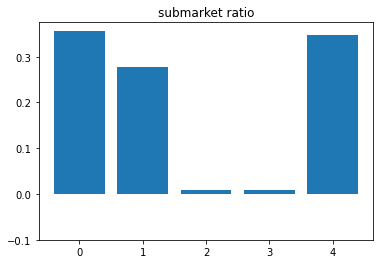

In [5]:
plt.bar(range(best_model.T), best_model.π)
plt.ylim(-0.1, None)
plt.title("submarket ratio")
plt.show()

### Get Segmentation Result
It is fussy clustering

In [6]:
probs = best_model.responsibility(
    X=x.reshape(-1,1), 
    Exog=np.stack([np.ones_like(x), x]).T,
    Y = y
)

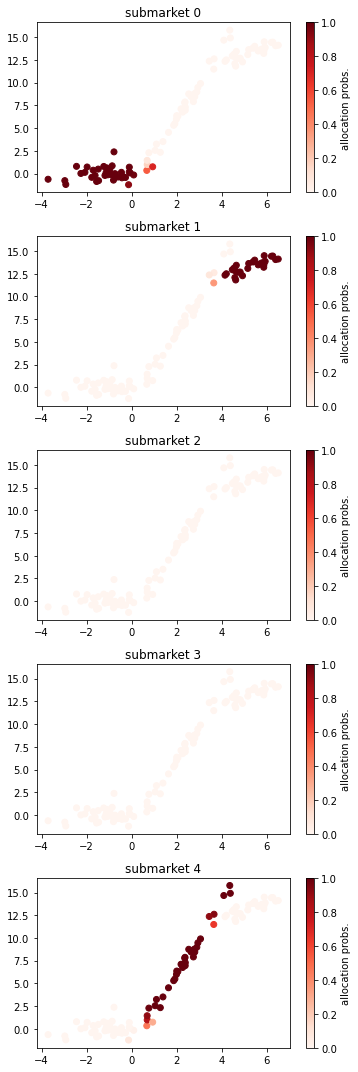

In [7]:
plt.figure(figsize=(5, T*3))
for t in range(T):
    plt.subplot(T, 1, t+1)
    plt.scatter(x, y, c=probs[:,t], vmin=0, vmax=1, cmap=plt.cm.Reds)
    plt.colorbar(label="allocation probs.")
    plt.title(f"submarket {t}")

plt.tight_layout()
plt.show()

### confusion matrix

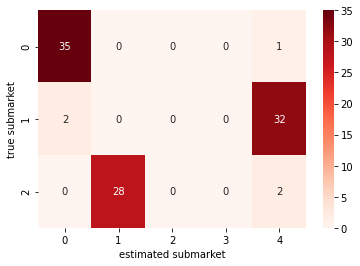

In [8]:
map_submarket = np.argmax(probs, axis=1)

confusion = np.empty((K, T), dtype=int)
for k in range(K):
    confusion[k] = np.count_nonzero(map_submarket[z==k][None] == np.arange(T)[:,None], axis=1)

sns.heatmap(confusion, cmap=plt.cm.Reds, annot=True)
plt.xlabel("estimated submarket")
plt.ylabel("true submarket")
plt.show()

### Coefficients

In [9]:
corespondance = np.argmax(confusion, axis=1)
corespondance

array([0, 4, 1])

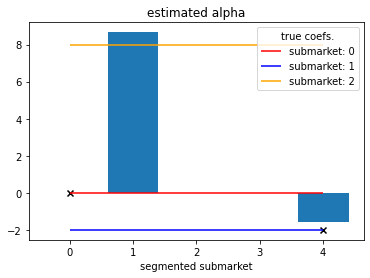

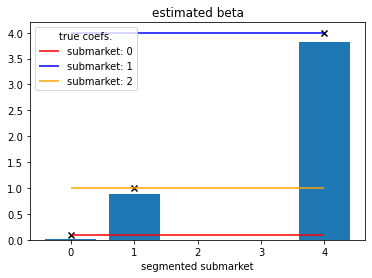

In [10]:
plt.bar(range(T), best_model.τ.Regre.ω_[:,0].flatten())
for k in range(K):
    plt.hlines(alpha[k], 0, T-1, label=f"submarket: {k}", color=color[k])
plt.scatter(corespondance, alpha, marker="x", color="k")
plt.legend(title="true coefs.")
plt.title("estimated alpha")
plt.xlabel("segmented submarket")
plt.show()

plt.bar(range(T), best_model.τ.Regre.ω_[:,1].flatten())
for k in range(K):
    plt.hlines(beta[k], 0, T-1, label=f"submarket: {k}", color=color[k])
plt.scatter(corespondance, beta, marker="x", color="k")
plt.legend(title="true coefs.")
plt.title("estimated beta")
plt.xlabel("segmented submarket")
plt.show()

## Case 2: dummy is included
### Build toy dataset

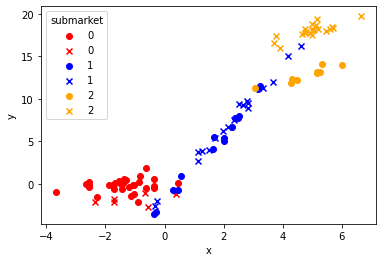

In [11]:
K = 3

mu = np.array([-1, 2, 5])
tau = np.array([1, 1.1, 0.8])

p = np.array([0.1, 0.5, 0.8])

gamma = np.array([-2, 0.3, 5])
beta = np.array([0.1, 4, 1])
alpha = np.array([0.0, -2, 8])
sigma = np.array([0.8, 0.5, 0.4])

def toy_dataset(N):
    z = np.random.choice(range(K), size=N, replace=True)
    x = np.random.normal(loc=mu[z], scale=tau[z])
    d = (np.random.uniform(size=N) < p[z]).astype(int)

    y = alpha[z] + beta[z] * x + gamma[z] * d + np.random.normal(scale=sigma[z])

    return y, x, d, z

N = 100
y, x, d, z = toy_dataset(N)

marker = ["o", "x"]
color = ["Red", "Blue", "Orange"]
for k in range(K):
    for i in [0,1]:
        mask = d[z==k] == i
        plt.scatter(x[z==k][mask], y[z==k][mask], label=k, marker=marker[i], c=color[k])
plt.legend(title="submarket")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


### Model
Infinite Gaussian Bernoulli Regression Mixture Model (IGBRMM)

`BayesianMarketSegmentation.NISHI` is an alias of `BayesianMarketSegmentation.IGBRMM`

In [12]:
model = BayesianMarketSegmentation.NISHI(
    X=x.reshape(-1,1),
    dummy=d.reshape(-1,1),
    Exog=np.stack([np.ones_like(x), x, d]).T,
    Y = y
)

### Inference

In [13]:
T=5
best_model = BayesianMarketSegmentation.IterativeVI_II(model, trial=5, T=T, maxiter=100)

### Get Segmentation Results

In [14]:
probs = best_model.responsibility(
    X=x.reshape(-1,1), 
    dummy=d.reshape(-1,1),
    Exog=np.stack([np.ones_like(x), x, d]).T,
    Y = y
)

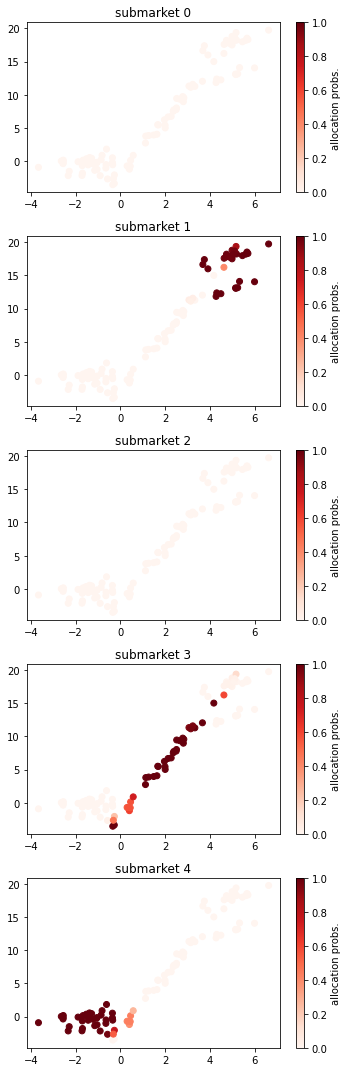

In [15]:
plt.figure(figsize=(5, T*3))
for t in range(T):
    plt.subplot(T, 1, t+1)
    plt.scatter(x, y, c=probs[:,t], vmin=0, vmax=1, cmap=plt.cm.Reds)
    plt.colorbar(label="allocation probs.")
    plt.title(f"submarket {t}")

plt.tight_layout()
plt.show()

### Confusion matrix

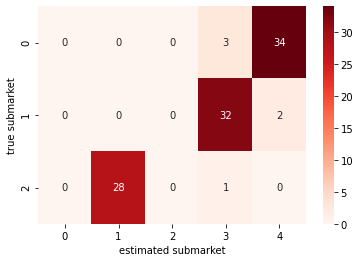

In [16]:
map_submarket = np.argmax(probs, axis=1)

confusion = np.empty((K, T), dtype=int)
for k in range(K):
    confusion[k] = np.count_nonzero(map_submarket[z==k][None] == np.arange(T)[:,None], axis=1)

sns.heatmap(confusion, cmap=plt.cm.Reds, annot=True)
plt.xlabel("estimated submarket")
plt.ylabel("true submarket")
plt.show()

In [17]:
corespondance = np.argmax(confusion, axis=1)
corespondance

array([4, 3, 1])

### Coefficients

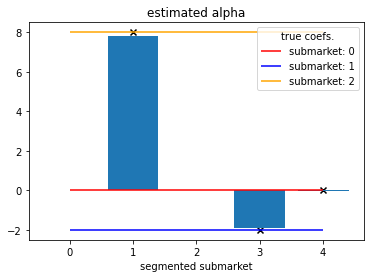

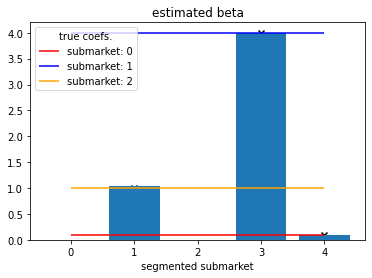

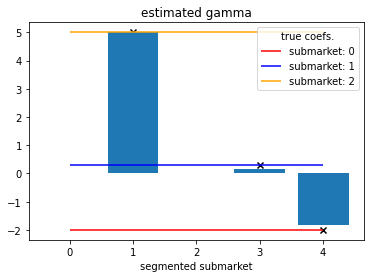

In [18]:
plt.bar(range(T), best_model.τ.Regre.ω_[:,0].flatten())
for k in range(K):
    plt.hlines(alpha[k], 0, T-1, label=f"submarket: {k}", color=color[k])
plt.scatter(corespondance, alpha, marker="x", color="k")
plt.legend(title="true coefs.")
plt.title("estimated alpha")
plt.xlabel("segmented submarket")
plt.show()

plt.bar(range(T), best_model.τ.Regre.ω_[:,1].flatten())
for k in range(K):
    plt.hlines(beta[k], 0, T-1, label=f"submarket: {k}", color=color[k])
plt.scatter(corespondance, beta, marker="x", color="k")
plt.legend(title="true coefs.")
plt.title("estimated beta")
plt.xlabel("segmented submarket")
plt.show()

plt.bar(range(T), best_model.τ.Regre.ω_[:,2].flatten())
for k in range(K):
    plt.hlines(gamma[k], 0, T-1, label=f"submarket: {k}", color=color[k])
plt.scatter(corespondance, gamma, marker="x", color="k")
plt.legend(title="true coefs.")
plt.title("estimated gamma")
plt.xlabel("segmented submarket")
plt.show()